# CoxPH-EWAS unadjusted with overall survival as outcome

```{contents}
```

## Load and process clinical data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
clinical_data_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Processed_Data/'


df_methyl = pd.read_pickle(
    input_path+'df_batch_uncorrected.pkl')

print(
    f' Dataset (df) contains {df_methyl.shape[1]} columns (5mC nucleotides/probes) and {df_methyl.shape[0]} rows (samples).')

# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                         labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df_methyl.index)]

 Dataset (df) contains 333352 columns (5mC nucleotides/probes) and 3330 rows (samples).


## Remove samples based on certain clinical features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [2]:
df1 = df_labels[df_labels['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df_labels.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')


2049 samples were removed. 1281 samples remaining.


### Select diagnostic bone marrow samples only

In [3]:
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

350 samples were removed. 931 samples remaining.


### Remove duplicate samples

In [4]:
df3 = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df3.shape[0]} samples were removed. {df3.shape[0]} samples remaining.')


7 samples were removed. 924 samples remaining.


### Match samples in clinical data to samples in methylation data

In [5]:
# Match samples in clinical data to samples in methylation data
df_methyl_filtered = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 1:]

print('Samples in clinical data matched to samples in methylation data.')

Samples in clinical data matched to samples in methylation data.


## Transform to M-values

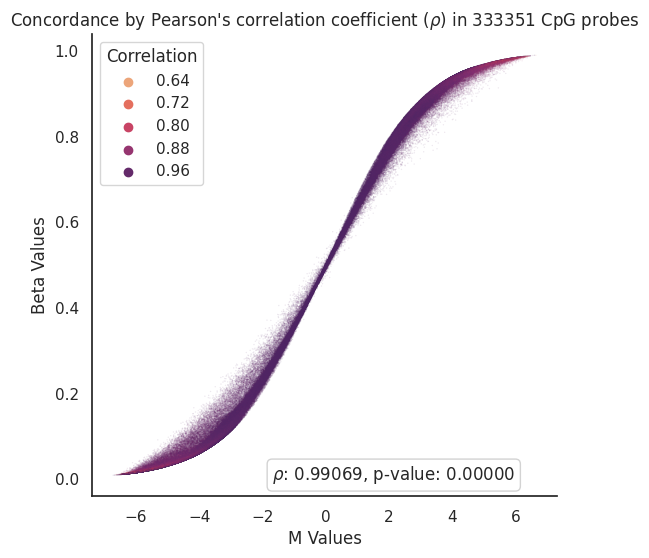

In [6]:
# df_methyl_clipped = df_methyl_filtered.clip(0.001, 0.999)

import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df_methyl_filtered.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df_methyl_filtered, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df_methyl_filtered.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
                 bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Run EWAS no samples batch corrected

Probes: 100%|██████████| 333351/333351 [41:45<00:00, 133.05it/s] 


Saved ../Data/Processed_Data/ewas_cog_os_nobatch.


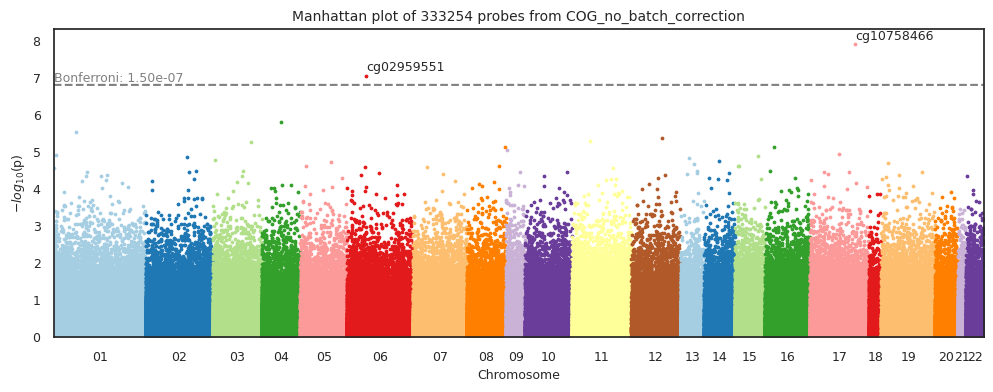

In [7]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

ewas_cog_nobatch = methylize.diff_meth_pos(meth_data = x_train_m,
                                    duration = df3['os.time'],
                                    event_observed = df3['os.evnt'],
                                    pheno_data = df3['os.time'], # not used
                                    covariates = False,
                                    regression_method = "coxph",
                                    export = 'pkl',
                                    verbose = True,
                                    filename=output_path + 'ewas_cog_os_nobatch')

ewas_cog_nobatch = pd.read_pickle(output_path + 'ewas_cog_os_nobatch.pkl')

methylize.manhattan_plot(stats_results=ewas_cog_nobatch,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG_no_batch_correction",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


## Step 9. Perform batch correction

In [18]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_batchcorrected = pycombat(data = x_train_m.T, batch = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]).round(3)

print('Succesfully corrected batch effects in the training dataset.')


Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

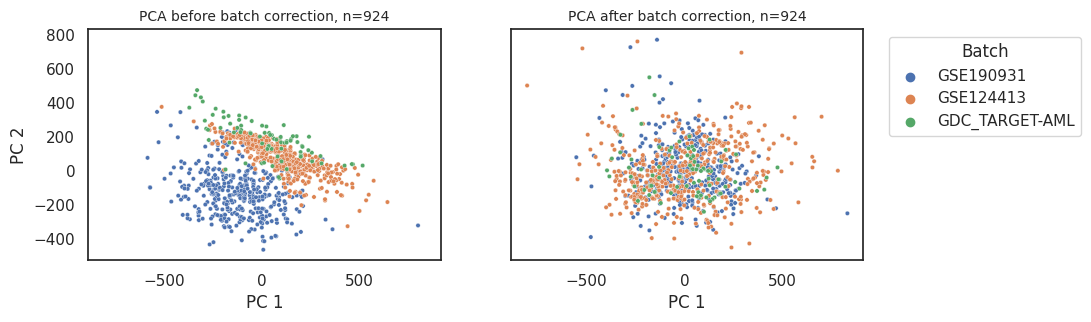

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

X_std = standardize_data(df_batchcorrected)
principal_components = perform_pca(X_std)
pcs_batchcorrected = create_principal_df(principal_components, df_batchcorrected)

X_std = standardize_data(x_train_m.T)
principal_components = perform_pca(X_std)
pcs_uncorrected = create_principal_df(principal_components, x_train_m.T)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(pcs_batchcorrected, pcs_uncorrected)


## Run EWAS COG samples batch corrected

In [30]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

ewas_cog_corrected = methylize.diff_meth_pos(meth_data = df_batchcorrected,
                                    duration = df3['os.time'],
                                    event_observed = df3['os.evnt'],
                                    pheno_data = df3['os.time'], # not used
                                    covariates = False,
                                    regression_method = "coxph",
                                    export = 'pkl',
                                    verbose = True,
                                    filename=output_path + 'ewas_cog_os_batch_corrected')

ewas_cog_corrected = pd.read_pickle(output_path + 'ewas_cog_os_batch_corrected.pkl')

methylize.manhattan_plot(stats_results=ewas_cog_corrected,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG_with_batch_correction",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


Probes:  14%|█▍        | 46840/333351 [05:58<37:07, 128.64it/s] 

## Run EWAS all samples batch corrected

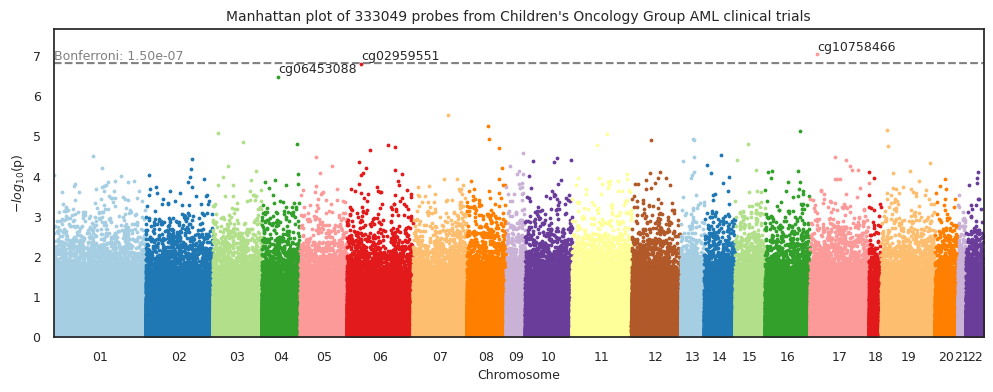

In [18]:
# import methylize
# import seaborn as sns
# sns.set_theme(style="white")

# # ewasOS_un = methylize.diff_meth_pos(meth_data = x_train_m,
# #                                     duration = df3['os.time'],
# #                                     event_observed = df3['os.evnt'],
# #                                     pheno_data = df3['os.time'], # not used
# #                                     covariates = False,
# #                                     regression_method = "coxph",
# #                                     export = 'pkl',
# #                                     verbose = True,
# #                                     filename=output_path + 'ewas_cog_os_unadjusted')

# ewasOS_un = pd.read_pickle(output_path + 'ewas_cog_os_unadjusted.pkl')

# methylize.manhattan_plot(stats_results=ewasOS_un,
#                         palette='Paired',
#                         save=False,
#                         suggestive=False,
#                         significant= False,
#                         width=12,
#                         height=4,
#                         statsmode=False,
#                         bonferroni=True,
#                         fontsize=9,
#                         array_type='450k',
#                         explore=False,
#                         border = True,
#                         label_sig_probes=True,
#                         fwer=0.05,
#                         cohorts= " Children's Oncology Group AML clinical trials",
#                         filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


## Table top results by p-value

In [13]:
ewas_top = ewasOS_un.sort_values(by='PValue').head(10).iloc[:,:-3]
ewas_top

,Coefficient,StandardError,HazardsRatio,95%CI_lower,95%CI_upper,ZScore,PValue,FDR_QValue
cg10758466,-0.240239,0.044954,0.786440,0.720114,0.858876,-5.344147,9.084404e-08,0.026436
cg02959551,-0.292930,0.055878,0.746074,0.668680,0.832426,-5.242278,1.586062e-07,0.026436
cg06453088,-0.147930,0.028994,0.862492,0.814845,0.912924,-5.102090,3.359236e-07,0.037327
cg08122885,0.121177,0.025894,1.128825,1.072965,1.187593,4.679711,2.872789e-06,0.239412
cg22272840,0.091995,0.020261,1.096360,1.053675,1.140773,4.540507,5.611907e-06,0.302352
cg14125846,-0.370650,0.082376,0.690286,0.587368,0.811237,-4.499463,6.812542e-06,0.302352
cg10294820,-0.162761,0.036314,0.849794,0.791413,0.912482,-4.482065,7.392431e-06,0.302352
cg18060030,-0.173763,0.038999,0.840496,0.778646,0.907259,-4.455637,8.364463e-06,0.302352
cg09755939,-0.376726,0.084731,0.686104,0.581122,0.810052,-4.446153,8.742158e-06,0.302352
cg08259755,-0.250416,0.057035,0.778477,0.696141,0.870551,-4.390562,1.130581e-05,0.302352


## Fetch genes from top CpGs

In [15]:
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames','GeneClasses', 'TranscriptIDs','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
ewasOS_un_genes = zhou2016_probes.join(ewas_top[['PValue']],how='inner').sort_values(by='PValue')
ewasOS_un_genes


,chrm,start,end,GeneNames,GeneClasses,TranscriptIDs,CGIPosition,PValue
cg10758466,chr17,43896718,43896720,MPP2;MPP2;MPP2;MPP2;MPP2;MPP2;MPP2;MPP2;MPP2;M...,protein_coding;protein_coding;protein_coding;p...,ENST00000269095.7;ENST00000377184.6;ENST000004...,N_Shelf,9.084404e-08
cg02959551,chr6,31659208,31659210,C6orf47;C6orf47-AS1,protein_coding;antisense,ENST00000375911.1;ENST00000422049.1,N_Shore,1.586062e-07
cg06453088,chr4,5885997,5885999,CRMP1;CRMP1;CRMP1;CRMP1;CRMP1,protein_coding;protein_coding;protein_coding;p...,ENST00000324989.10;ENST00000397890.5;ENST00000...,N_Shore,3.359236e-07
cg08122885,chr7,38976449,38976451,.,.,.,S_Shore,2.872789e-06
cg22272840,chr8,10729371,10729373,CTD-2135J3.3;CTD-2135J3.3;CTD-2135J3.4;SOX7,antisense;antisense;protein_coding;protein_coding,ENST00000506149.2;ENST00000519568.1;ENST000005...,Island,5.611907e-06
cg14125846,chr19,38948540,38948542,CTC-360G5.8;FBXO17;FBXO17;FBXO17;FBXO17;FBXO17...,protein_coding;protein_coding;protein_coding;p...,ENST00000599996.1;ENST00000292852.7;ENST000005...,N_Shore,6.812542e-06
cg10294820,chr16,86196091,86196093,LINC01082;RP11-805I24.3,lincRNA;lincRNA,ENST00000601250.1;ENST00000599841.1,.,7.392431e-06
cg18060030,chr3,169249449,169249451,MECOM;MECOM;MECOM,protein_coding;protein_coding;protein_coding,ENST00000481315.1;ENST00000485957.1;ENST000004...,.,8.364463e-06
cg09755939,chr11,15115141,15115143,INSC;INSC,protein_coding;protein_coding,ENST00000379554.6;ENST00000379556.6,S_Shore,8.742158e-06
cg08259755,chr8,55525160,55525162,XKR4;XKR4;XKR4,protein_coding;protein_coding;protein_coding,ENST00000327381.6;ENST00000518261.1;ENST000006...,.,1.130581e-05


## Watermark

In [16]:
%load_ext watermark

In [17]:
%watermark -v -p methylize,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylize: 1.1.1
pandas   : 2.0.1

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

